### Installing Lucent 

In [2]:
!pip install --quiet git+https://github.com/atagade/lucent

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00


### Importing libraries

In [3]:
import torch
import urllib.request 
import numpy as np
from PIL import Image
from lucent.modelzoo import custom_resnet
from lucent.optvis import objectives, transform, param, render
from lucent.optvis.render import hook_model

### Setting up labels list

In [4]:
labels_str = ""
for line in urllib.request.urlopen("https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt"):
    labels_str += line.decode('utf-8')

labels = [line[line.find(" "):].strip() for line in labels_str.split("\n")]
labels = [label[label.find(" "):].strip().replace("_", " ") for label in labels]
labels = ["dummy"] + labels

### Using custom resnet from Lucent

In [5]:
import torch
from lucent.modelzoo import custom_resnet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = custom_resnet.resnet18(pretrained = True, skip_batchnorm = False).to(device).eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


### Helper functions

In [14]:
def raw_class_spatial_attr(img, layer, label, transforms=None, override=None):
  """How much did spatial positions at a given layer effect a output class?"""

  img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
  normalize = (
      transform.preprocess_inceptionv1()
      if model._get_name() == "InceptionV1"
      else transform.normalize()
  )
  transforms = [
      normalize,
      torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
  ]

  transforms_f = transform.compose(transforms)
  img = img.unsqueeze(0)
  img = transforms_f(img)

  scores, acts = model.forward(img, layer = layer)
  score = scores[0, labels.index(label)]
  grad = torch.autograd.grad(score, acts)[0]

  return torch.sum(acts * grad, axis = -1)[0].detach()
  
def visualise_max_activated_neurons(model, img_path, layer, label, k=1):

  img = np.array(Image.open(img_path), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=layer, label=label)

  channel_list = attr.max(-1)[0].topk(k)[1]

  param_f = lambda: param.image(224)

  for i in range(k):
    obj = objectives.channel(layer, channel_list[i])
    image = render.render_vis(model, obj, param_f, preprocess = True, show_inline = True)

### Running the demo
NOTE: 
1. File paths may change from code listed below
2. CPU execution time = approx 3 minutes
3. GPU execution time = approx 6 seconds 
4. To get the max activated neurons reliably for a particular label, make sure that the image you're using is a good indicator of the label 


#### Download images from the web

In [7]:
!wget https://distill.pub/2018/building-blocks/examples/input_images/dog_cat.jpeg

--2023-04-14 04:44:21--  https://distill.pub/2018/building-blocks/examples/input_images/dog_cat.jpeg
Resolving distill.pub (distill.pub)... 151.101.65.195, 151.101.1.195
Connecting to distill.pub (distill.pub)|151.101.65.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17153 (17K) [image/jpeg]
Saving to: ‘dog_cat.jpeg’

dog_cat.jpeg        100%[===================>]  16.75K  --.-KB/s    in 0s      

2023-04-14 04:44:21 (70.3 MB/s) - ‘dog_cat.jpeg’ saved [17153/17153]



100%|██████████| 512/512 [03:21<00:00,  2.54it/s]



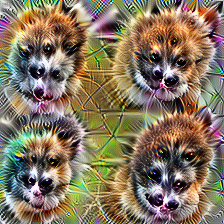

In [15]:
visualise_max_activated_neurons(model, img_path='/content/dog_cat.jpeg', layer='layer3', label='Labrador retriever')

#### Upload your own images

Saving dog_cat.jpeg to dog_cat (1).jpeg


100%|██████████| 512/512 [02:40<00:00,  3.19it/s]



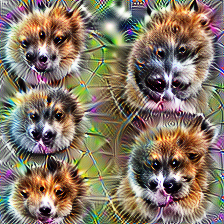

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  visualise_max_activated_neurons(model, fn, layer='layer3', label='Labrador retriever')
